In [5]:
import torch
import torchvision
import torchvision.transforms as T
import pandas as pd
from PIL import Image
import os
import logging
from torch.utils.data import Dataset
import torch.nn as nn
from torchvision import models

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch version: 2.5.1+cu118
Device: cuda


In [2]:
acuity_path = "../acuityvalues_modified_based_on_sphere.xlsx"

df = pd.read_excel(acuity_path)

display(df.head())

print("Columns in the dataset:")
print(df.columns)

,patient,r sphere,r cylinder,l sphere,l cylinder,r class,l class
0,1,0.25,-0.25,0.00,-0.25,2,0
1,2,-0.50,-0.50,0.00,-0.50,1,0
2,3,1.75,-0.75,0.00,-0.25,2,0
3,4,0.25,0.00,0.25,0.00,2,2
4,5,0.25,0.25,0.25,0.00,2,2


Columns in the dataset:
Index(['patient', 'r sphere', 'r cylinder', 'l sphere', 'l cylinder',
       'r class', 'l class'],
      dtype='object')


In [3]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import logging

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Dataset Class
class EyeDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        patient_id = int(row['patient'])  # Ensure patient ID is an integer
        left_image_path = os.path.normpath(os.path.join(self.root_dir, str(patient_id), f"{patient_id}_LEFT_IR.jpg"))
        right_image_path = os.path.normpath(os.path.join(self.root_dir, str(patient_id), f"{patient_id}_RIGHT_IR.jpg"))

        # Check if image files exist
        if not os.path.exists(left_image_path):
            raise FileNotFoundError(f"Left IR image not found: {left_image_path}")
        if not os.path.exists(right_image_path):
            raise FileNotFoundError(f"Right IR image not found: {right_image_path}")

        # Load images
        left_image = Image.open(left_image_path).convert("RGB")
        right_image = Image.open(right_image_path).convert("RGB")

        if self.transform:
            left_image = self.transform(left_image)
            right_image = self.transform(right_image)

        # Labels
        labels = torch.tensor([row['r class'], row['l class']], dtype=torch.long)

        return (left_image, right_image), labels

# Load cleaned data
cleaned_data_path = "cleaned_data.csv"
if not os.path.exists(cleaned_data_path):
    raise FileNotFoundError(f"Cleaned data file not found: {cleaned_data_path}")

logging.info("Loading cleaned data...")
cleaned_data = pd.read_csv(cleaned_data_path)

# Ensure patient IDs are integers in the DataFrame
cleaned_data['patient'] = cleaned_data['patient'].apply(lambda x: int(x))

# Split data
logging.info("Splitting data into training and testing sets...")
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=42)

# Define transformations
logging.info("Defining image transformations...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets
logging.info("Creating datasets...")
train_dataset = EyeDataset(train_data, root_dir="../Choithram Netralaya Data/Images", transform=transform)
test_dataset = EyeDataset(test_data, root_dir="../Choithram Netralaya Data/Images", transform=transform)

# Data loaders
logging.info("Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

logging.info("Data loaders created successfully.")

2024-12-25 20:33:06,801 - INFO - Loading cleaned data...
2024-12-25 20:33:06,806 - INFO - Splitting data into training and testing sets...
2024-12-25 20:33:06,810 - INFO - Defining image transformations...
2024-12-25 20:33:06,810 - INFO - Creating datasets...
2024-12-25 20:33:06,810 - INFO - Creating data loaders...
2024-12-25 20:33:06,815 - INFO - Data loaders created successfully.


In [6]:
from torchvision.models import EfficientNet_B3_Weights

class EyeClassificationModelB3(nn.Module):
    def __init__(self, num_classes=3):
        super(EyeClassificationModelB3, self).__init__()
        # Load EfficientNet B3
        self.efficientnet = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, 256)  # Feature extraction

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 256),  # Combine left and right eye features
            nn.ReLU(),
            nn.Linear(256, num_classes * 2)  # Predict for r class and l class
        )

    def forward(self, left_image, right_image):
        # Extract features from left and right images
        left_features = self.efficientnet(left_image)
        right_features = self.efficientnet(right_image)

        # Concatenate features
        combined_features = torch.cat((left_features, right_features), dim=1)

        # Pass through fully connected layers
        outputs = self.fc(combined_features)

        # Separate outputs for r class and l class
        r_class_output = outputs[:, :3]  # First three outputs for r class
        l_class_output = outputs[:, 3:]  # Next three outputs for l class
        return r_class_output, l_class_output


In [7]:
# Initialize EfficientNet B3 model
model_b3 = EyeClassificationModelB3(num_classes=3).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_b3.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\sksse/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:07<00:00, 6.45MB/s]


In [10]:
# Training function
def train_model_b3(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        print(f"Epoch {epoch + 1}/{epochs}")

        for batch_idx, ((left_images, right_images), labels) in enumerate(dataloader):
            left_images, right_images = left_images.to(device), right_images.to(device)
            r_class_labels, l_class_labels = labels[:, 0].to(device), labels[:, 1].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            r_class_output, l_class_output = model(left_images, right_images)

            # Compute loss
            loss_r = criterion(r_class_output, r_class_labels)
            loss_l = criterion(l_class_output, l_class_labels)
            loss = loss_r + loss_l

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:  # Print progress every 10 batches
                print(f"  Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}")

        print(f"Epoch {epoch + 1} completed, Average Loss: {running_loss / len(dataloader):.4f}")


In [11]:
def evaluate_model_b3(model, dataloader):
    model.eval()
    correct_r, correct_l = 0, 0
    total = 0

    with torch.no_grad():
        for (left_images, right_images), labels in dataloader:
            left_images, right_images = left_images.to(device), right_images.to(device)
            r_class_labels, l_class_labels = labels[:, 0].to(device), labels[:, 1].to(device)

            # Forward pass
            r_class_output, l_class_output = model(left_images, right_images)

            # Predictions
            _, predicted_r = torch.max(r_class_output, 1)
            _, predicted_l = torch.max(l_class_output, 1)

            total += labels.size(0)
            correct_r += (predicted_r == r_class_labels).sum().item()
            correct_l += (predicted_l == l_class_labels).sum().item()

    accuracy_r = 100 * correct_r / total
    accuracy_l = 100 * correct_l / total
    print(f"Right Eye Accuracy: {accuracy_r:.2f}%")
    print(f"Left Eye Accuracy: {accuracy_l:.2f}%")


In [12]:
print("Training EfficientNet B3 model...")
train_model_b3(model_b3, train_loader, criterion, optimizer, epochs=30)


Training EfficientNet B3 model...
Epoch 1/30
  Batch 10/33, Loss: 0.6364
  Batch 20/33, Loss: 1.2561
  Batch 30/33, Loss: 1.0728
Epoch 1 completed, Average Loss: 1.5398
Epoch 2/30
  Batch 10/33, Loss: 1.2409
  Batch 20/33, Loss: 3.3211
  Batch 30/33, Loss: 1.0993
Epoch 2 completed, Average Loss: 1.2468
Epoch 3/30
  Batch 10/33, Loss: 0.6393
  Batch 20/33, Loss: 1.2175
  Batch 30/33, Loss: 0.9655
Epoch 3 completed, Average Loss: 1.0908
Epoch 4/30
  Batch 10/33, Loss: 1.2412
  Batch 20/33, Loss: 0.7641
  Batch 30/33, Loss: 0.1633
Epoch 4 completed, Average Loss: 0.8110
Epoch 5/30
  Batch 10/33, Loss: 0.9702
  Batch 20/33, Loss: 0.7697
  Batch 30/33, Loss: 0.8788
Epoch 5 completed, Average Loss: 1.0384
Epoch 6/30
  Batch 10/33, Loss: 1.5243
  Batch 20/33, Loss: 2.7833
  Batch 30/33, Loss: 1.0420
Epoch 6 completed, Average Loss: 0.8685
Epoch 7/30
  Batch 10/33, Loss: 0.9458
  Batch 20/33, Loss: 0.6829
  Batch 30/33, Loss: 0.2747
Epoch 7 completed, Average Loss: 0.7095
Epoch 8/30
  Batch 10

In [13]:
print("Evaluating EfficientNet B3 model...")
evaluate_model_b3(model_b3, test_loader)

Evaluating EfficientNet B3 model...
Right Eye Accuracy: 75.76%
Left Eye Accuracy: 77.27%


In [14]:
def evaluate_model_with_metrics(model, dataloader):
    model.eval()
    correct_r, correct_l = 0, 0
    total = 0

    r_class_true, r_class_pred = [], []
    l_class_true, l_class_pred = [], []

    with torch.no_grad():
        for (left_images, right_images), labels in dataloader:
            left_images, right_images = left_images.to(device), right_images.to(device)
            r_class_labels, l_class_labels = labels[:, 0].to(device), labels[:, 1].to(device)

            # Forward pass
            r_class_output, l_class_output = model(left_images, right_images)

            # Predictions
            _, predicted_r = torch.max(r_class_output, 1)
            _, predicted_l = torch.max(l_class_output, 1)

            # Store true and predicted labels
            r_class_true.extend(r_class_labels.cpu().numpy())
            r_class_pred.extend(predicted_r.cpu().numpy())
            l_class_true.extend(l_class_labels.cpu().numpy())
            l_class_pred.extend(predicted_l.cpu().numpy())

            total += labels.size(0)
            correct_r += (predicted_r == r_class_labels).sum().item()
            correct_l += (predicted_l == l_class_labels).sum().item()

    accuracy_r = 100 * correct_r / total
    accuracy_l = 100 * correct_l / total
    print(f"Right Eye Accuracy: {accuracy_r:.2f}%")
    print(f"Left Eye Accuracy: {accuracy_l:.2f}%")

    return r_class_true, r_class_pred, l_class_true, l_class_pred

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predicted_labels, title):
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Power", "Myopia", "Hypermetropia"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

Right Eye Accuracy: 75.76%
Left Eye Accuracy: 77.27%


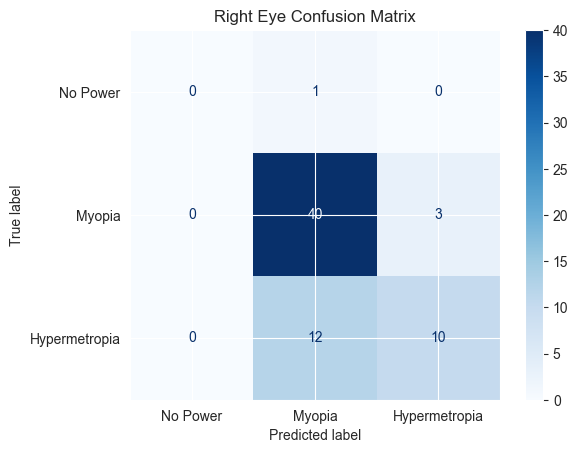

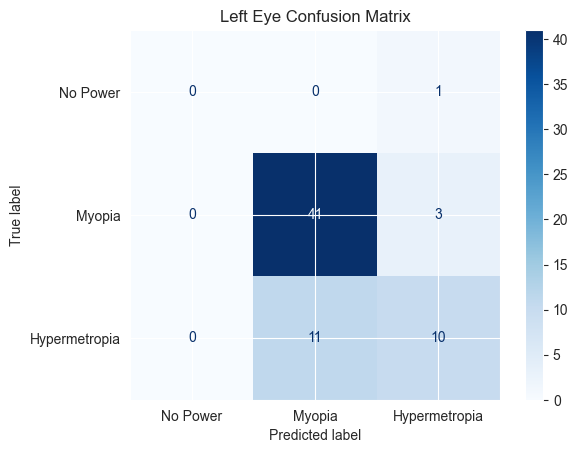

In [16]:
r_class_true, r_class_pred, l_class_true, l_class_pred = evaluate_model_with_metrics(model_b3, test_loader)

plot_confusion_matrix(r_class_true, r_class_pred, "Right Eye Confusion Matrix")

# Left Eye Confusion Matrix
plot_confusion_matrix(l_class_true, l_class_pred, "Left Eye Confusion Matrix")

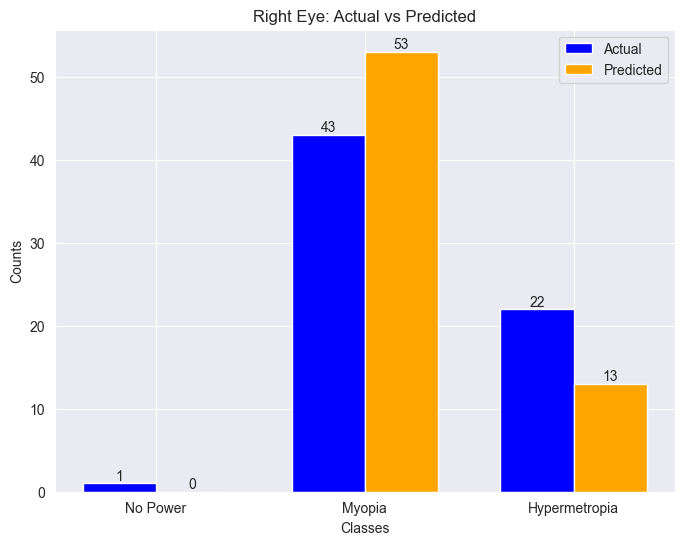

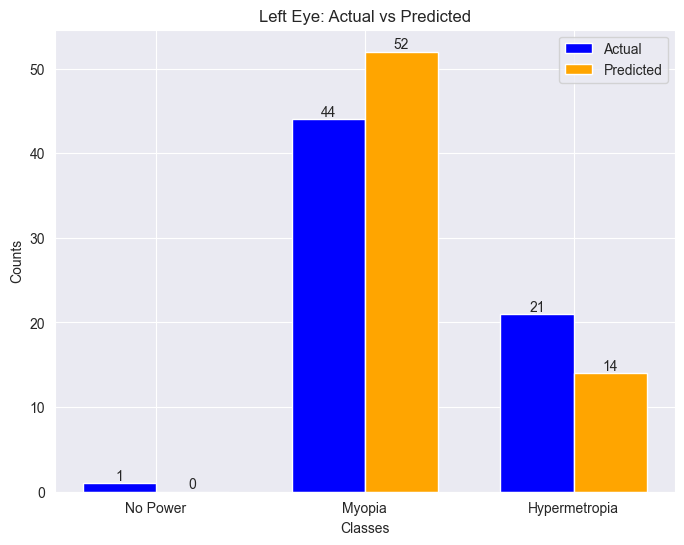

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(actual, predicted, title):
    classes = ["No Power", "Myopia", "Hypermetropia"]

    # Count occurrences for each class
    actual_counts = [actual.count(i) for i in range(3)]
    predicted_counts = [predicted.count(i) for i in range(3)]

    # Plotting
    x = np.arange(len(classes))  # Class indices
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(8, 6))
    bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual', color='blue')
    bars2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted', color='orange')

    # Add labels, title, and legend
    ax.set_xlabel('Classes')
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    # Add value labels on the bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

    plt.show()

# Plot for Right Eye
plot_actual_vs_predicted(r_class_true, r_class_pred, "Right Eye: Actual vs Predicted")

# Plot for Left Eye
plot_actual_vs_predicted(l_class_true, l_class_pred, "Left Eye: Actual vs Predicted")


In [19]:
torch.save(model_b3.state_dict(), "efficientnet_b3_model_acc_75_77.pth")
print("EfficientNet B3 model saved successfully!")


EfficientNet B3 model saved successfully!


In [20]:
model_b3 = EyeClassificationModelB3(num_classes=3).to(device)
model_b3.load_state_dict(torch.load("efficientnet_b3_model_acc_75_77.pth"))
model_b3.eval()


C:\Users\sksse\AppData\Local\Temp\ipykernel_20416\2532985731.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_b3.load_state_dict(torch.load("efficientnet_b3_model_a

EyeClassificationModelB3(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
  

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToPILImage

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

    def save_forward_activations(self, module, input, output):
        """Capture the forward activations."""
        self.activations = output

    def save_backward_gradients(self, module, grad_input, grad_output):
        """Capture the backward gradients."""
        self.gradients = grad_output[0]

    def generate_cam(self, left_image, right_image, class_idx, eye='r'):
        """Generate the Grad-CAM heatmap."""
        # Register hooks to capture activations and gradients
        forward_hook = self.target_layer.register_forward_hook(self.save_forward_activations)
        backward_hook = self.target_layer.register_backward_hook(self.save_backward_gradients)

        # Forward pass
        r_class_output, l_class_output = self.model(left_image, right_image)
        output = r_class_output if eye == 'r' else l_class_output

        # Backward pass for the desired class
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward(retain_graph=True)

        # Remove hooks to avoid conflicts
        forward_hook.remove()
        backward_hook.remove()

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze(0).cpu().detach().numpy()

        # Normalize and resize using Pillow
        cam = np.maximum(cam, 0)
        height, width = left_image.size(2), left_image.size(3)  # Correctly get height and width
        cam_image = Image.fromarray(cam)
        cam = np.array(cam_image.resize((width, height), resample=Image.BILINEAR))  # Pass (width, height) as a tuple
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

def visualize_gradcam(left_image, right_image, class_idx, grad_cam, original_image, eye='r'):
    """Visualize the Grad-CAM heatmap blended with the original image."""
    cam = grad_cam.generate_cam(left_image, right_image, class_idx, eye)
    heatmap = np.uint8(255 * cam)
    heatmap = Image.fromarray(heatmap).convert("RGB")
    heatmap = heatmap.resize(original_image.size, resample=Image.BILINEAR)
    heatmap = np.array(heatmap)

    # Blend the heatmap with the original image
    heatmap = heatmap / 255.0  # Normalize to [0, 1]
    blended = heatmap + np.float32(original_image) / 255
    blended = blended / np.max(blended)

    # Display the result
    plt.imshow(blended)
    plt.title(f"Grad-CAM Visualization for {eye.upper()} Eye")
    plt.axis('off')
    plt.show()

In [53]:
# Initialize Grad-CAM
target_layer = model_b3.efficientnet.features[-1]  # Final convolutional layer of EfficientNet B3
grad_cam = GradCAM(model_b3, target_layer)

# Get a batch of test images
test_batch = next(iter(test_loader))
(left_images, right_images), labels = test_batch

# Select one image (e.g., left and right images of the first patient)
original_image = ToPILImage()(left_images[0])  # Convert tensor to a PIL image
left_image = left_images[0].unsqueeze(0).to(device)  # Add batch dimension
right_image = right_images[0].unsqueeze(0).to(device)  # Add batch dimension

# Class index to visualize (e.g., Myopia)
class_idx = 1  # Myopia

# Generate Grad-CAM for the left eye
visualize_gradcam(left_image, right_image, class_idx, grad_cam, np.array(original_image), eye='l')


D:\Power-Prediction\venv\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


TypeError: 'int' object is not iterable